In [1]:
import numpy as np
import h5py
import keras
from collections import OrderedDict
import gzip

celltype_to_corefiles = {   
    'A549': {
        'scores_h5file': 'A549_scores_5k.h5',
        'scores_seqids': 'A549_toppredpos_5k.txt',
        'motifscoringresults_json': 'A549_motifscoring_results.json.gz',
        'positive_sequences_file': "/users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.valid.bed.gz",
        'motifmatches_file': '/users/eprakash/projects/benchmarking/newdata/A549/A549.motif.matches.txt',
    },
    'HepG2': {
        'scores_h5file': 'HepG2_scores_5k.h5',
        'scores_seqids': 'HepG2_toppredpos_5k.txt',
        'motifscoringresults_json': 'HepG2_motifscoring_results.json.gz',
        'positive_sequences_file': "/users/eprakash/projects/benchmarking/newdata/HepG2/HepG2.summits.400bp.implanted.valid.bed.gz",
        'motifmatches_file': '/users/eprakash/projects/benchmarking/newdata/HepG2/HepG2.motif.matches.txt',
    },
    'H1ESC': {
        'scores_h5file': 'H1ESC_scores_5k.h5',
        'scores_seqids': 'H1ESC_toppredpos_5k.txt',
        'motifscoringresults_json': 'H1ESC_motifscoring_results.json.gz',
        'positive_sequences_file': "/users/eprakash/projects/benchmarking/newdata/H1ESC/H1ESC.summits.400bp.implanted.valid.bed.gz",
        'motifmatches_file': '/users/eprakash/projects/benchmarking/newdata/H1ESC/H1ESC.motif.matches.txt',
    }
}


Using TensorFlow backend.


In [30]:
import json
from collections import defaultdict


def onehot_encode(seqs):
    ltr = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], 'N': [0,0,0,0]}
    return np.array([[ltr[x] for x in seq.upper()] for seq in seqs])


def get_indices_of_subset(superset_seqnames, subset_seqnames):
    seqname_to_idx = dict([(x[1], x[0]) for x in enumerate(superset_seqnames)])
    idx_ordering = [seqname_to_idx[x] for x in subset_seqnames]
    return idx_ordering


def load_posseqs(corefiles, pos_idx_ordering):
    all_posseqs = [x.decode("utf-8").rstrip().split("\t")[1]
                   for x in gzip.open(corefiles['positive_sequences_file'])]
    posseqs = [all_posseqs[idx] for idx in pos_idx_ordering]
    return onehot_encode(posseqs), posseqs


def load_scores(corefiles, onehot_seqs):
    h5pyfile = h5py.File(corefiles['scores_h5file'], "r")
    method_to_scores = {}
    for method in h5pyfile.keys():
        scores = np.array(h5pyfile[method][:])
        #sanity check with onehot_seqs
        assert np.max(np.abs(np.sum(scores*onehot_seqs, axis=-1)
                             - np.sum(scores, axis=-1)))==0.0
        method_to_scores[method] = np.sum(scores,axis=-1)
    return method_to_scores


def get_scores_for_common_sequences(corefiles):
    #######
    #Load all the seqnames
    positives_seqnames = [x.decode("utf-8").rstrip().split("\t")[0]
                          for x in gzip.open(corefiles['positive_sequences_file'])]
    subset_seqnames = [x.rstrip() for x in open(corefiles['scores_seqids'])]   
    ########
    #Figure out the mapping from sequence to indices for the common seqnames
    positives_idx_ordering = get_indices_of_subset(superset_seqnames=positives_seqnames,
                                                   subset_seqnames=subset_seqnames)
    ########
    #Load the data using the idx ordering
    onehot_posseqs, posseqs = load_posseqs(corefiles=corefiles,
                                           pos_idx_ordering=positives_idx_ordering)
    method_to_scores = load_scores(corefiles=corefiles,onehot_seqs=onehot_posseqs)  
    #strip away the 'dinuc_shuffled_motifs_implanted_' from the front
    seqnames = [x.replace("dinuc_shuffled_motifs_implanted_", "")
                for x in subset_seqnames]
    return method_to_scores, onehot_posseqs, posseqs, seqnames


def get_extomotifs_from_motifnametohitlocations(motifname_to_hitlocations):
    ex_to_motifs = defaultdict(list)
    for motifname in motifname_to_hitlocations:
        for exidx,start in motifname_to_hitlocations[motifname]:
            ex_to_motifs[exidx].append((motifname, start))
    return ex_to_motifs


A549_method_to_scores, A549_onehot_seqs, A549_seqs, A549_seqnames =\
        get_scores_for_common_sequences(corefiles=celltype_to_corefiles['A549'])
HepG2_method_to_scores, HepG2_onehot_seqs, HepG2_seqs, HepG2_seqnames =\
        get_scores_for_common_sequences(corefiles=celltype_to_corefiles['HepG2'])
H1ESC_method_to_scores, H1ESC_onehot_seqs, H1ESC_seqs, H1ESC_seqnames =\
        get_scores_for_common_sequences(corefiles=celltype_to_corefiles['H1ESC'])
    
A549_motifscoring_results = json.loads(
        gzip.open("A549_motifscoring_results.json.gz").read())
A549_motifname_to_hitlocations = A549_motifscoring_results['motifname_to_hitlocations']
A549_extomotifs = get_extomotifs_from_motifnametohitlocations(A549_motifname_to_hitlocations)
A549_motifname_to_method_to_hitscores = A549_motifscoring_results['motifname_to_method_to_hitscores']

HepG2_motifscoring_results = json.loads(
        gzip.open("HepG2_motifscoring_results.json.gz").read())
HepG2_motifname_to_hitlocations = HepG2_motifscoring_results['motifname_to_hitlocations']
HepG2_extomotifs = get_extomotifs_from_motifnametohitlocations(HepG2_motifname_to_hitlocations)
HepG2_motifname_to_method_to_hitscores = HepG2_motifscoring_results['motifname_to_method_to_hitscores']

H1ESC_motifscoring_results = json.loads(
        gzip.open("H1ESC_motifscoring_results.json.gz").read())
H1ESC_motifname_to_hitlocations = H1ESC_motifscoring_results['motifname_to_hitlocations']
H1ESC_extomotifs = get_extomotifs_from_motifnametohitlocations(H1ESC_motifname_to_hitlocations)
H1ESC_motifname_to_method_to_hitscores = H1ESC_motifscoring_results['motifname_to_method_to_hitscores']


In [48]:
from deeplift.visualization import viz_sequence


def get_ranks(scores):
    sorted_scores = sorted(scores)
    return [np.searchsorted(a=sorted_scores, v=x) for x in scores]


def print_examples_with_scorediff_on_motif(
         method_to_hitscores,
         ex_to_motifs,
         motiflocs,
         onehot_seqs,
         method_to_scores,
         method1, method2,
         numtoprint, methodstoprint,
         motifname,
         minmethod2=0.0,
         region_around=None):
    method1_scores = method_to_hitscores[method1]
    method1_ranks = get_ranks(method1_scores)
    method2_scores = method_to_hitscores[method2]
    method2_ranks = get_ranks(method2_scores)
    idxs = [x[0] for x in sorted(enumerate(zip(method1_ranks,method2_ranks)),
                                    key=lambda x: x[1][0]-x[1][1])
                  if x[1][1] > minmethod2][:numtoprint]
    themotiflocs = [motiflocs[x] for x in idxs]
    for idx in idxs:
        (exidx, motifpos) = motiflocs[idx]
        print(sorted(ex_to_motifs[exidx], key=lambda x: x[1]))
        method1_score, method2_score = method1_scores[idx], method2_scores[idx]  
        method1_rank, method2_rank = method1_ranks[idx], method2_ranks[idx]  
        print(exidx, motifpos, method1)
        print(method1_score,method2_score, method1_rank, method2_rank)
        for methodname in methodstoprint:
            print(methodname)
            print(sum(method_to_scores[methodname][exidx][motifpos:motifpos+len(motifname)]))
            toplot = (method_to_scores[methodname][exidx][:,None]
                      *onehot_seqs[exidx])
            if (region_around is None):
                viz_sequence.plot_weights(toplot, subticks_frequency=20)
            else:
                viz_sequence.plot_weights(toplot[motifpos-region_around:
                                                 motifpos+(len(motifname))+region_around],
                                                 subticks_frequency=10)


In [49]:
methodstoprint = ['gradtimesinp',
                   'intgrad20_dinucshuffref10',
                   'dlrescale_dinucshuffref10',
                   'ism']

[('CTCCCCCT', 17), ('TCGCGTTTCC', 18), ('NBNSCCTTTARN', 18), ('WAMCGCGS', 20), ('NBNSCCTTTARN', 57), ('TTAAAVMGCS', 58), ('GCCTTTTA', 59), ('AAGCCTTTTC', 63), ('THTGCAAATGNN', 64), ('GCCTTTTA', 65), ('RYCGAATGGAGG', 83), ('ATTCCATTCG', 85), ('BRYTTCCGSY', 87), ('KCCGGTTT', 92), ('GCGGACTA', 92), ('ARVVVGCGBN', 93), ('CTCCTCCC', 101), ('GGGAAAAA', 112), ('NMTTSGTTCGVN', 113), ('NNRAWTTCCH', 133), ('GGACCCGCCCCC', 142), ('GGGGCGGG', 143), ('GAGCGCGCGCGC', 144), ('CTCCTCCC', 155), ('ATAACAAAGG', 171), ('CNYYTAGCGS', 192), ('CGCCGCTCTA', 196), ('CCAATCGG', 215), ('CGCCCTCT', 238), ('ARVVVGCGBN', 273), ('CGCCCTCT', 273), ('ARVVVGCGBN', 296), ('GCGGACTA', 310), ('ATTCCATTCG', 322), ('STGACGTCACCG', 333), ('RGGGGAGGRG', 359), ('CTCCTCCC', 359), ('GCGGACTA', 376), ('AAGCCTTTTC', 382), ('TARGCGGW', 392)]
1337 171 gradtimesinp
-0.5957193970680237 2.912433385848999 63 439
gradtimesinp
-0.5957193970680237


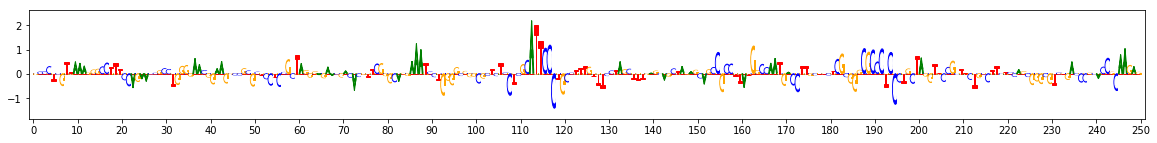

intgrad20_dinucshuffref10
0.30567931137629795


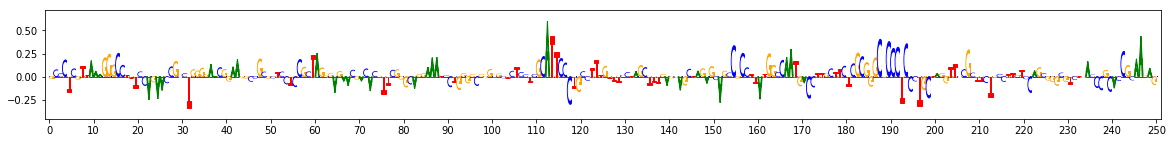

dlrescale_dinucshuffref10
0.4451705750077963


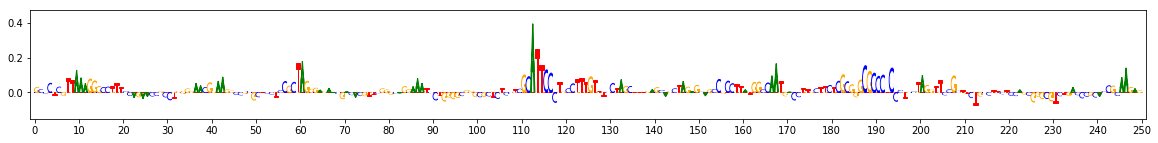

ism
2.912433385848999


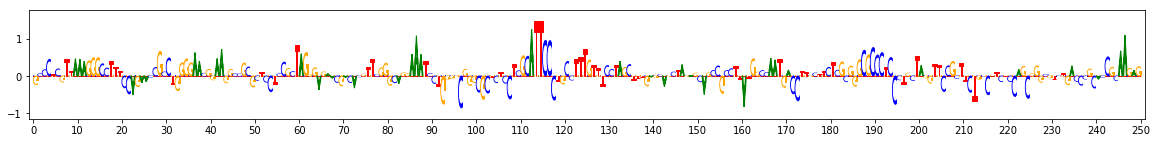

[('GCCTTTTA', 25), ('ATAACAAAGG', 26), ('WSCGAATS', 34), ('ATTCCATTCG', 36), ('TTTTTTTYCCCC', 83), ('GGGAAAAA', 86), ('GGGGCGGG', 96), ('TTTTTTTYCCCC', 115), ('SWRGCAAC', 116), ('CTGCGGTTTT', 126), ('TTTTTTTYCCCC', 132), ('GGGAAAAA', 132), ('NBNSCCTTTARN', 138), ('GCCTTTTA', 141), ('ATAACAAAGG', 160), ('TTTTTTTYCCCC', 161), ('NNRAWTTCCH', 175), ('ACATTCCY', 177), ('NBNSCCTTTARN', 178), ('TGAAAGGVAM', 179), ('TARGCGGW', 186), ('AAGCTTTC', 187), ('ATAACAAAGG', 189), ('TTTTTTTYCCCC', 192), ('GGGAAAAA', 196), ('RGCCAATCGG', 223), ('CCAATCGG', 223), ('NMTTSGTTCGVN', 225), ('AAGCCTTTTC', 232), ('TTTTTTTYCCCC', 246), ('GGGAAAAA', 247), ('TGCAAATC', 302), ('CGCCGCTCTA', 309), ('WAMCGCGS', 311), ('CSVTAGCRAC', 352)]
4391 189 gradtimesinp
-0.4687949465587735 3.0348598957061768 76 448
gradtimesinp
-0.4687949465587735


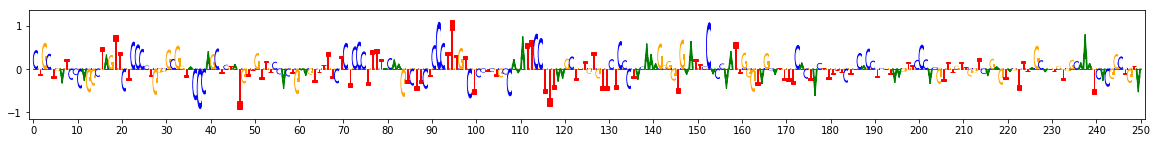

intgrad20_dinucshuffref10
0.154200263065286


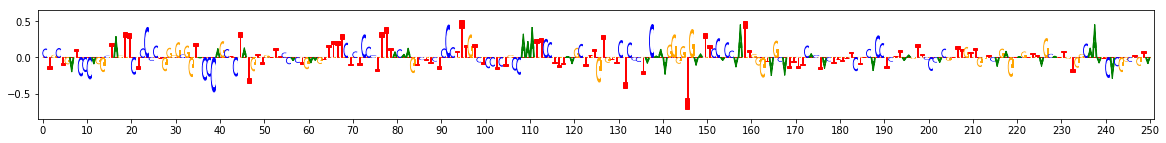

dlrescale_dinucshuffref10
0.2772158254869282


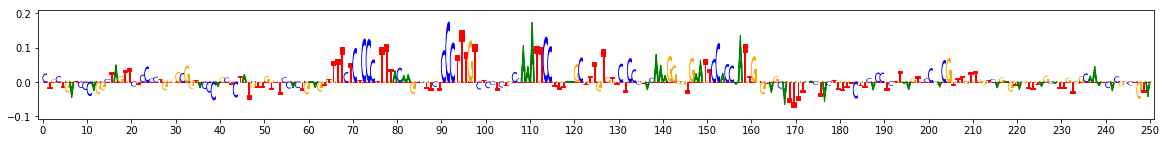

ism
3.0348598957061768


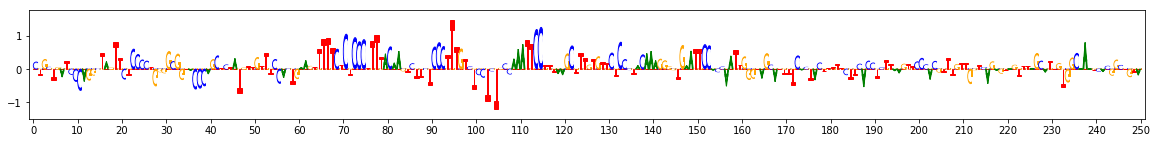

In [62]:
print_examples_with_scorediff_on_motif(
    method_to_hitscores=H1ESC_motifname_to_method_to_hitscores['ATAACAAAGG'],
    ex_to_motifs=H1ESC_extomotifs,
    motiflocs=H1ESC_motifname_to_hitlocations['ATAACAAAGG'],
    onehot_seqs=H1ESC_onehot_seqs,
    method_to_scores=H1ESC_method_to_scores,
    method1='gradtimesinp',
    method2='ism',
    numtoprint=2,
    motifname='ATAACAAAGG',
    methodstoprint=methodstoprint,
    region_around=120)

[('GGGCGGGGCC', 0), ('GCCGCCGCCGCN', 36), ('CGGCGGCG', 38), ('SCGCSGCGSV', 38), ('BBCGKGGAAANK', 42), ('CGCVYGCGCG', 62), ('CTCTCGCG', 62), ('KCTCGCGCGA', 63), ('TTCGCTCCGS', 64), ('NSBSTCGCGVNC', 65), ('BCGCGGAR', 67), ('CGRCGCGCGS', 70), ('NSBSTCGCGVNC', 72), ('KCTCGCGCGA', 74), ('CGTCACTTCCGG', 94), ('YTCCTCCCCC', 94), ('TTCGCTCCGS', 95), ('CGRCGCGCGS', 106), ('CCAAWCGS', 117), ('AGAGGGCGCT', 124), ('TTCGCTCCGS', 126), ('CGCGCBCT', 126), ('NSBSTCGCGVNC', 127), ('CGRCGCGCGS', 127), ('CCAAWCGS', 142), ('CAGTCATK', 160), ('BCGCGGAR', 161), ('SCGCSGCGSV', 165), ('SSGCGCSSGCGC', 168), ('NSBSTCGCGVNC', 168), ('CGRCGCGCGS', 168), ('CGCVYGCGCG', 169), ('CGCGCBCT', 169), ('AGAGGGCGCT', 171), ('CTCTCGCG', 171), ('CGCGCBCT', 173), ('CGCVYGCGCG', 175), ('NSBSTCGCGVNC', 176), ('CTCTCGCG', 177), ('NNCCGCTTMCSN', 202), ('TTAACCGC', 204), ('GTTGCCANRB', 207), ('CGRCGCGCGS', 220), ('SCGCSGCGSV', 222), ('GGGGGCGGGGCC', 223), ('GGGGCGKA', 224), ('GGGGCGGRVCSG', 224), ('GGGCGGGGCC', 225), ('NSBSTCGCGVN

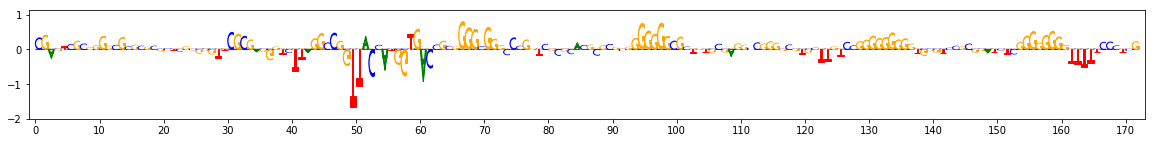

intgrad20_dinucshuffref10
0.9406108649738599


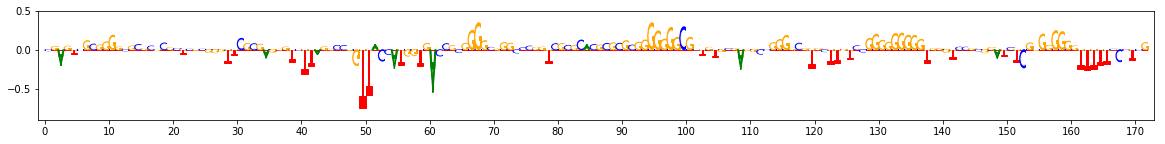

dlrescale_dinucshuffref10
1.0797198944259434


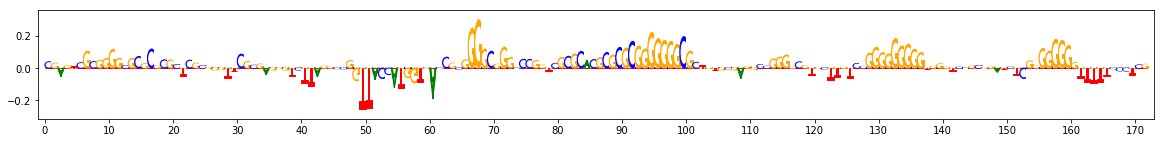

ism
0.16167068481445312


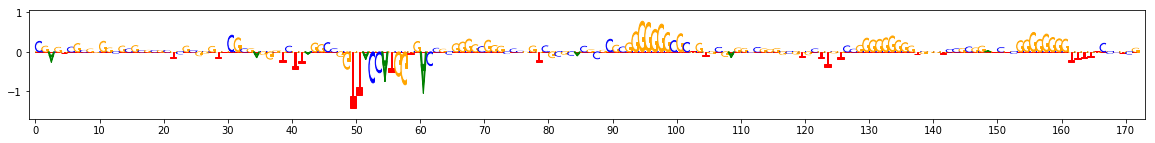

[('GGGGCGGRVCSG', 17), ('SCGCSGCGSV', 21), ('GGGGCGKA', 21), ('GGGCGGGGCC', 23), ('GGGGGCGGGGCC', 23), ('GGCGGCGC', 24), ('AGAGGGCGCT', 26), ('VGGAGGAR', 31), ('SGACCGAA', 38), ('VGGAGGAR', 51), ('CGCVYGCGCG', 61), ('CGGCGGCG', 61), ('BCGCGGAR', 62), ('GGCGGCGC', 62), ('AAAACGMG', 65), ('SGACCGAA', 86), ('GCGCGGCGCCGC', 99), ('CGRCGCGCGS', 100), ('SCGCSGCGSV', 102), ('GCCGCCGCCGCN', 103), ('CGGCGGCG', 105), ('SSGCGCSSGCGC', 107), ('CGCVYGCGCG', 108), ('CGGCGGCG', 108), ('GGCGGCGC', 109), ('GCGCGGCGCCGC', 110), ('TTCGCTCCGS', 110), ('SCGCSGCGSV', 112), ('BCGCGGAR', 113), ('GGCGGCGC', 114), ('GCGCGGCGCCGC', 115), ('GCCGCCGCCGCN', 130), ('SCGCSGCGSV', 132), ('CGCVYGCGCG', 133), ('GCGCGGCGCCGC', 134), ('CGGCGGCG', 135), ('CGRCGCGCGS', 138), ('CGCGCBCT', 141), ('BCGCGGAR', 144), ('SSGCGCSSGCGC', 144), ('GGCGGCGC', 144), ('CGCVYGCGCG', 145), ('CGGCGGCG', 145), ('CGGCGGCG', 151), ('CTGTTTRC', 166), ('TTAACCGC', 167), ('AGAGGGCGCT', 170), ('GGGGCGKA', 170), ('CGCVYGCGCG', 172), ('CGGCGGCG', 17

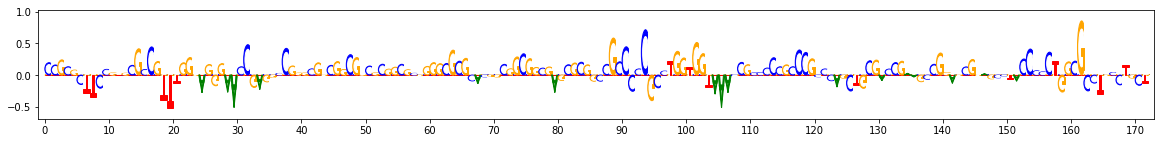

intgrad20_dinucshuffref10
0.5414878344163299


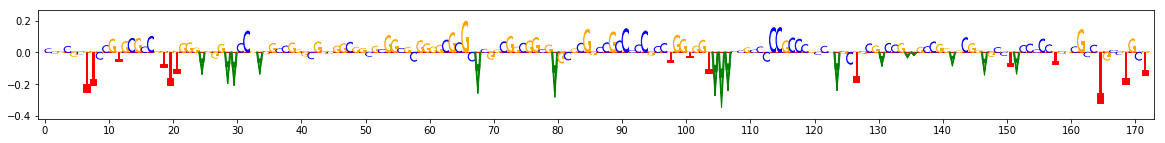

dlrescale_dinucshuffref10
0.6735275207087398


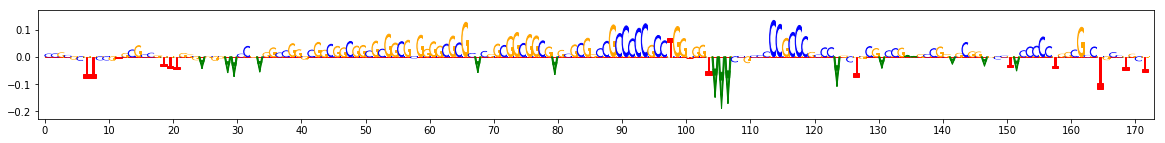

ism
-0.26601266860961914


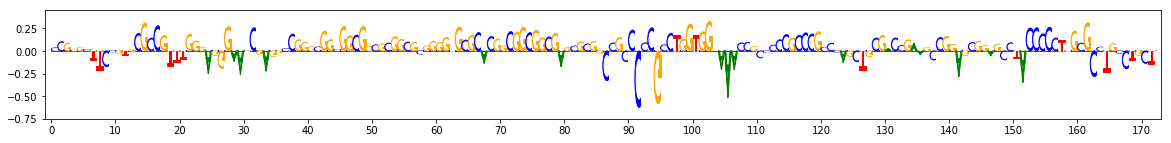

[('GCGCGGCGCCGC', 27), ('CGGCGGCG', 31), ('CGCVYGCGCG', 34), ('CGRCGCGCGS', 55), ('CCGCCCTCCSGC', 55), ('TTCGCTCCGS', 85), ('VGGAGGAR', 86), ('CGCVYGCGCG', 92), ('NNCRAABCCG', 92), ('TVTGCGCA', 94), ('TTGCGTAA', 95), ('GCGCGGCGCCGC', 131), ('GGGGCGGRVCSG', 132), ('GGGCGGGGCC', 133), ('YTCCTCCCCC', 135), ('CGCVYGCGCG', 138), ('KCTCGCGCGA', 139), ('CTCTCGCG', 140), ('ACAAATCC', 157), ('TTGCGTAA', 173), ('NNCRAABCCG', 176), ('GGGGCGGRVCSG', 178), ('YTCCTCCCCC', 181), ('CGCVYGCGCG', 184), ('TSGGAAMG', 189), ('NNCRAABCCG', 190), ('CGGCGGCG', 195), ('AGAGGGCGCT', 195), ('GGCGGCGC', 196), ('GCGCGGCGCCGC', 197), ('SCGCSGCGSV', 197), ('CGRCGCGCGS', 198), ('CGCVYGCGCG', 201), ('CGGCGGCG', 203), ('CGGCGGCG', 206), ('RCCGGAARYG', 207), ('SSGCGCSSGCGC', 208), ('CGCVYGCGCG', 209), ('GCGCGGCGCCGC', 214), ('BCGCGGAR', 214), ('SSGCGCSSGCGC', 224), ('CGCVYGCGCG', 225), ('CGRCGCGCGS', 228), ('SCGCSGCGSV', 229), ('GCGCGGCGCCGC', 232), ('SSGCGCSSGCGC', 240), ('CGCVYGCGCG', 241), ('GCGCGGCGCCGC', 246), ('BC

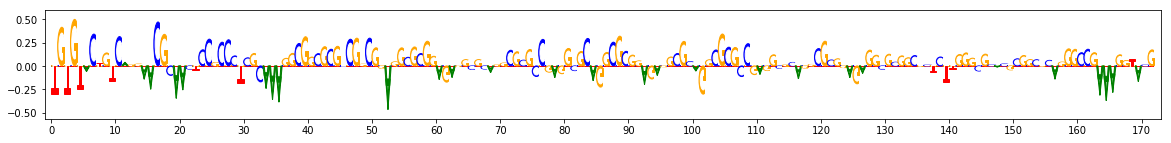

intgrad20_dinucshuffref10
0.26131707050371916


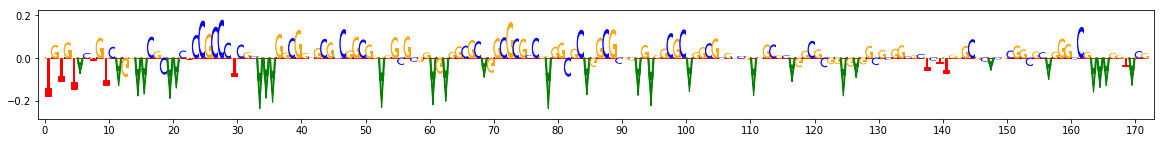

dlrescale_dinucshuffref10
0.6685182899236679


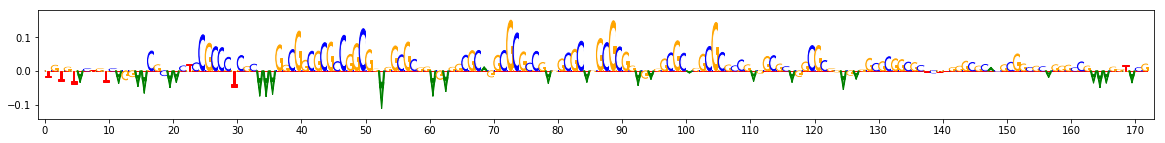

ism
-0.2847175598144531


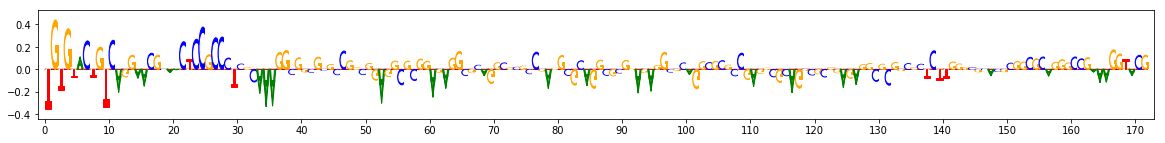

[('SCYYTARR', 10), ('CAGTCATK', 21), ('CCAAWCGS', 31), ('NMAABRTTTVYH', 50), ('VACWTTCC', 71), ('CGCVYGCGCG', 75), ('GCCGCCGCCGCN', 75), ('CGGCGGCG', 77), ('SCGCSGCGSV', 77), ('GGCGGCGC', 81), ('SCGCSGCGSV', 82), ('CGRCGCGCGS', 109), ('SCGCSGCGSV', 110), ('GCGCGGCGCCGC', 111), ('BCGCGGAR', 111), ('GGCGGCGC', 112), ('NSBSTCGCGVNC', 112), ('SSGCGCSSGCGC', 116), ('CGRCGCGCGS', 140), ('AGAGGGCGCT', 141), ('BCGCGGAR', 142), ('TTCGCTCCGS', 201), ('GCCGCCGCCGCN', 205), ('CGGCGGCG', 207), ('NNCRAABCCG', 207), ('GACGTCAC', 211), ('SCGCSGCGSV', 218), ('GCGCGGCGCCGC', 219), ('BCGCGGAR', 220), ('TVTGCGCA', 223), ('CGRCGCGCGS', 291), ('AGAGGGCGCT', 302), ('GCGCGGCGCCGC', 303), ('YTCCTCCCCC', 309), ('GGGGCGKA', 310), ('CGCVYGCGCG', 312), ('CGGCGGCG', 312), ('GGGGCGGRVCSG', 312), ('YTCCTCCCCC', 315), ('AGAGGGCGCT', 316), ('GGGGCGKA', 316), ('NSBSTCGCGVNC', 321), ('SSGCGCSSGCGC', 325), ('AGAGGGCGCT', 326), ('CGCGCBCT', 326), ('GCGCGGCGCCGC', 327), ('CGCVYGCGCG', 328), ('CGGCGGCG', 328), ('NSBSTCGCGVNC

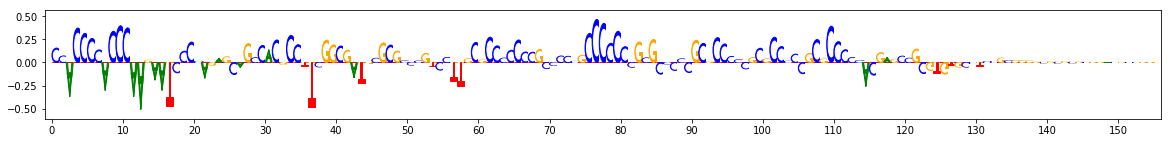

intgrad20_dinucshuffref10
0.5134667630540207


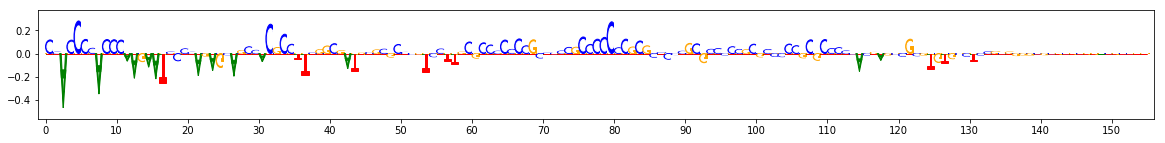

dlrescale_dinucshuffref10
0.6339464277029035


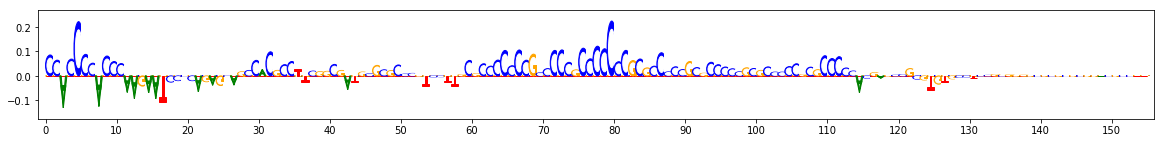

ism
-0.11049914360046387


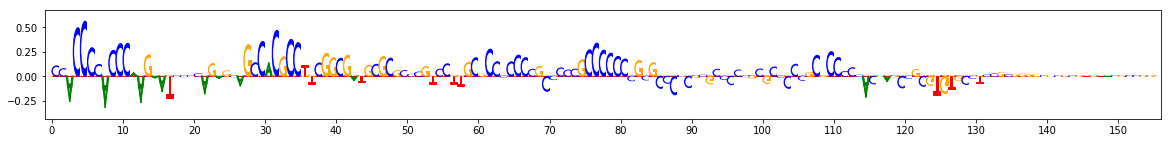

[('GCGCGGCGCCGC', 27), ('CGGCGGCG', 31), ('CGCVYGCGCG', 34), ('CGRCGCGCGS', 55), ('CCGCCCTCCSGC', 55), ('TTCGCTCCGS', 85), ('VGGAGGAR', 86), ('CGCVYGCGCG', 92), ('NNCRAABCCG', 92), ('TVTGCGCA', 94), ('TTGCGTAA', 95), ('GCGCGGCGCCGC', 131), ('GGGGCGGRVCSG', 132), ('GGGCGGGGCC', 133), ('YTCCTCCCCC', 135), ('CGCVYGCGCG', 138), ('KCTCGCGCGA', 139), ('CTCTCGCG', 140), ('ACAAATCC', 157), ('TTGCGTAA', 173), ('NNCRAABCCG', 176), ('GGGGCGGRVCSG', 178), ('YTCCTCCCCC', 181), ('CGCVYGCGCG', 184), ('TSGGAAMG', 189), ('NNCRAABCCG', 190), ('CGGCGGCG', 195), ('AGAGGGCGCT', 195), ('GGCGGCGC', 196), ('GCGCGGCGCCGC', 197), ('SCGCSGCGSV', 197), ('CGRCGCGCGS', 198), ('CGCVYGCGCG', 201), ('CGGCGGCG', 203), ('CGGCGGCG', 206), ('RCCGGAARYG', 207), ('SSGCGCSSGCGC', 208), ('CGCVYGCGCG', 209), ('GCGCGGCGCCGC', 214), ('BCGCGGAR', 214), ('SSGCGCSSGCGC', 224), ('CGCVYGCGCG', 225), ('CGRCGCGCGS', 228), ('SCGCSGCGSV', 229), ('GCGCGGCGCCGC', 232), ('SSGCGCSSGCGC', 240), ('CGCVYGCGCG', 241), ('GCGCGGCGCCGC', 246), ('BC

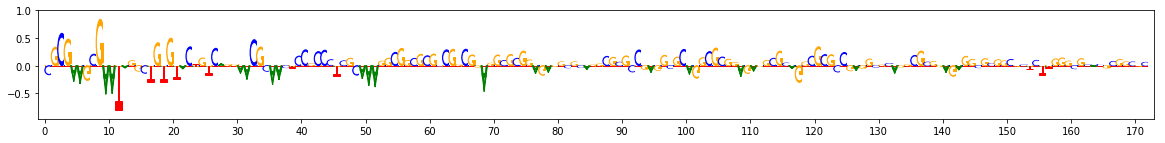

intgrad20_dinucshuffref10
0.6483869966585188


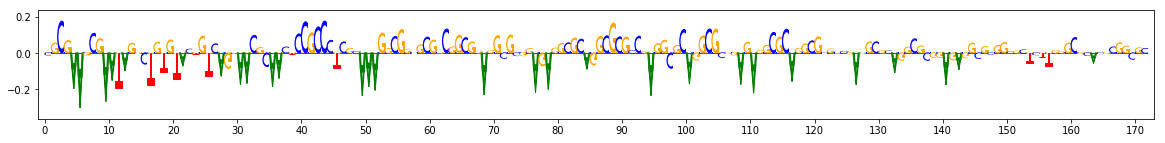

dlrescale_dinucshuffref10
0.6244211981538682


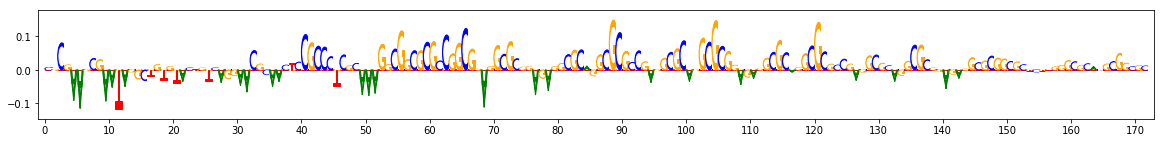

ism
0.06794095039367676


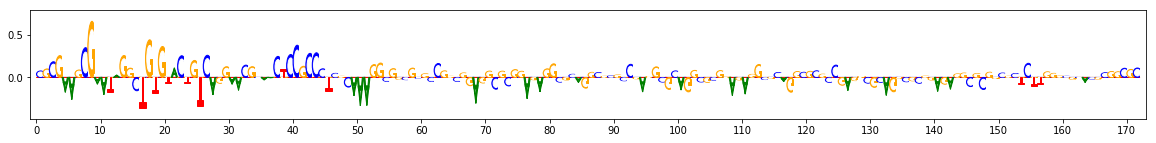

In [63]:
print_examples_with_scorediff_on_motif(
    method_to_hitscores=A549_motifname_to_method_to_hitscores['SSGCGCSSGCGC'],
    motiflocs=A549_motifname_to_hitlocations['SSGCGCSSGCGC'],
    ex_to_motifs = A549_extomotifs,
    onehot_seqs=A549_onehot_seqs,
    method_to_scores=A549_method_to_scores,
    method1='ism',
    method2='dlrescale_dinucshuffref10',
    numtoprint=5,
    minmethod2=1.0,
    motifname='SSGCGCSSGCGC',
    methodstoprint=methodstoprint,
    region_around=80)

[('CGCGCBCT', 15), ('BCGCGGAR', 16), ('GGCGGCGC', 16), ('NSBSTCGCGVNC', 16), ('GCGCGGCGCCGC', 17), ('SCGCSGCGSV', 19), ('BCGCGGAR', 20), ('TSGGAAMG', 34), ('ATTKCACAAC', 34), ('NNATGASTCATN', 50), ('ATGACTCATC', 51), ('STTAVTCABH', 52), ('TGASTCAB', 53), ('ATGACTCA', 53), ('CAGTCATK', 54), ('RCCGGAARYG', 79), ('NNCRAABCCG', 91), ('CCAAWCGS', 92), ('SCGCSGCGSV', 122), ('BCGCGGAR', 123), ('NSBSTCGCGVNC', 123), ('KCTCGCGCGA', 125), ('CTCTCGCG', 126), ('CGCVYGCGCG', 139), ('BCGCGGAR', 140), ('CGCGCBCT', 143), ('GGRAGTGTTT', 146), ('RCCGGAARYG', 149), ('CCGGAAAT', 150), ('TTCGCTCCGS', 152), ('GGGGCGKA', 154), ('NNCCGCTTMCSN', 168), ('CGGCGGCG', 187), ('CGTCACTTCCGG', 196), ('RCCGGAARYG', 199), ('TTCCNGGAAN', 200), ('TSGGAAMG', 200), ('CCGGAAAT', 200), ('TTCGCTCCGS', 204), ('CGCGCBCT', 228), ('VGGAGGAR', 241), ('NNCCGCTTMCSN', 256), ('GGGAAAAAAA', 264), ('NNCRAABCCG', 274), ('CGGCGGCG', 279), ('CTAGCGGC', 280), ('TTCGCTCCGS', 317), ('GBTTTCTCTCCS', 318), ('AAAACGMG', 326), ('CAGTCATK', 361),

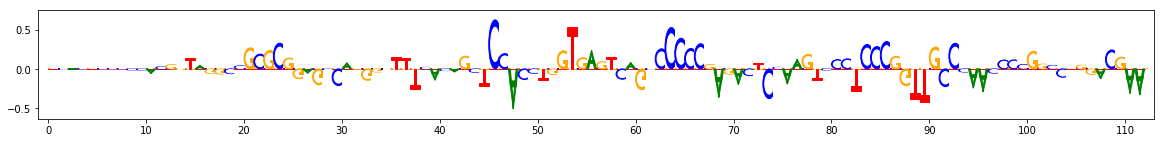

intgrad20_dinucshuffref10
0.25380764360888863


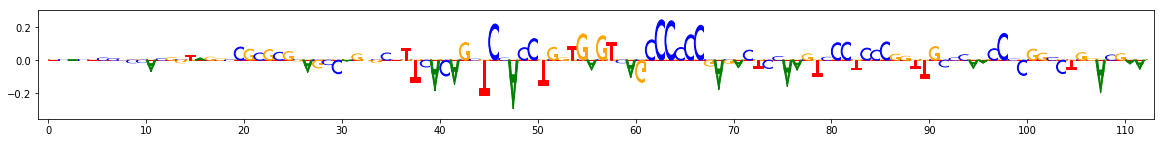

dlrescale_dinucshuffref10
0.8803242131602019


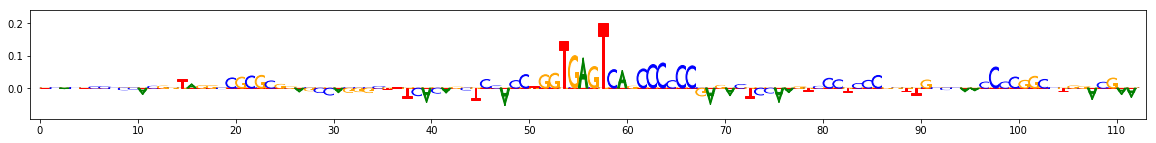

ism
3.2988972663879395


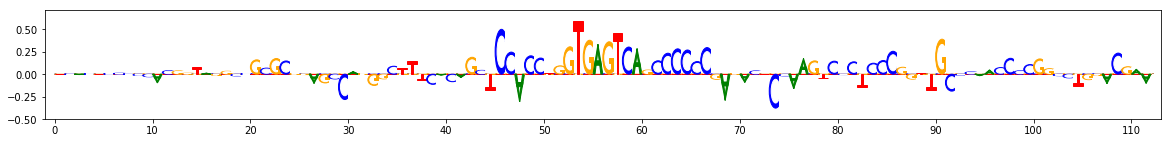

[('CTAGCGGC', 13), ('TTCGCTCCGS', 20), ('SGACCGAA', 21), ('CCAAWCGS', 42), ('VACWTTCC', 48), ('BBCGKGGAAANK', 50), ('TSGGAAMG', 51), ('BBCGKGGAAANK', 67), ('NAACAGGAARTB', 74), ('RCCGGAARYG', 76), ('GCGCGGCGCCGC', 83), ('RCCGGAARYG', 152), ('YTCCTCCCCC', 155), ('AAAACGMG', 189), ('TTCGCTCCGS', 238), ('GCCGCCGCCGCN', 240), ('SCGCSGCGSV', 241), ('BCGCGGAR', 242), ('CGGCGGCG', 242), ('NSBSTCGCGVNC', 252), ('SCGCSGCGSV', 253), ('GCCGCCGCCGCN', 255), ('GCGCGGCGCCGC', 256), ('GGCGGCGC', 256), ('CTCTCGCG', 271), ('CCGCCCTCCSGC', 316), ('CGRCGCGCGS', 318), ('GACGTCAC', 344), ('NNATGASTCATN', 345), ('STTAVTCABH', 347), ('ATGACTCATC', 347), ('TGASTCAB', 348), ('ATGACTCA', 348), ('CAGTCATK', 349), ('CCCCTAGTGGCC', 370), ('CTCTCGCG', 371), ('TTAACCGC', 392)]
3219 345 intgrad20_dinucshuffref10
0.23137488977517962 0.8542812037747352 49 132
gradtimesinp
-1.0065502226352692


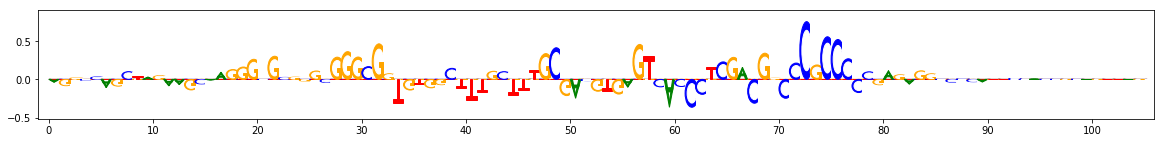

intgrad20_dinucshuffref10
0.23137488977517934


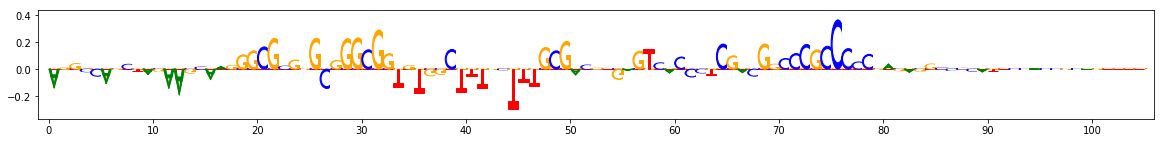

dlrescale_dinucshuffref10
0.8542812037747354


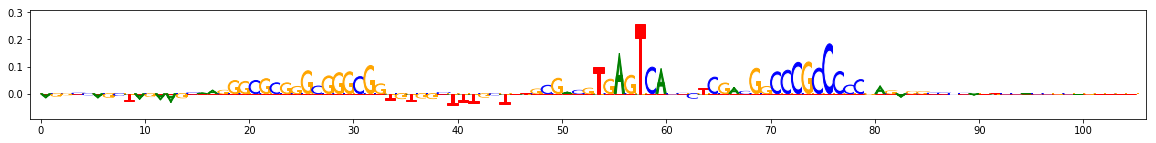

ism
1.86175537109375


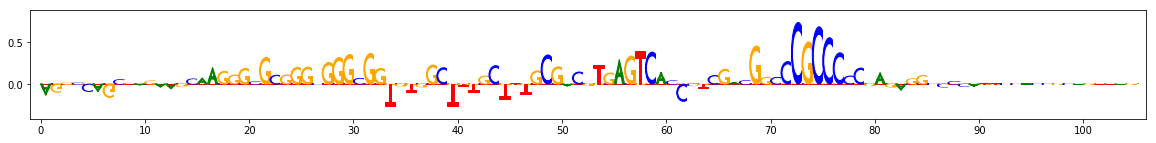

[('BCGCGGAR', 68), ('YTCCTCCCCC', 68), ('NSBSTCGCGVNC', 72), ('CGCVYGCGCG', 73), ('CGCGCBCT', 75), ('SCGCSGCGSV', 85), ('GGGGCGKA', 85), ('CGGCGGCG', 87), ('BBCGKGGAAANK', 108), ('CAGTCATK', 150), ('GCGCGGCGCCGC', 160), ('NNCRAABCCG', 169), ('CCAAWCGS', 171), ('SGACCGAA', 178), ('GGGGCGKA', 178), ('CCGCCCTCCSGC', 191), ('CGCVYGCGCG', 192), ('GGCGGCGC', 198), ('GCGCGGCGCCGC', 199), ('SCGCSGCGSV', 199), ('AGAGGGCGCT', 232), ('CGCGCBCT', 234), ('GCCGCCGCCGCN', 235), ('SCGCSGCGSV', 236), ('BCGCGGAR', 237), ('BBCGKGGAAANK', 238), ('GCGCGGCGCCGC', 239), ('CGGCGGCG', 240), ('TTCGCTCCGS', 242), ('GCGCGGCGCCGC', 263), ('BCGCGGAR', 271), ('SCGCSGCGSV', 271), ('AGAGGGCGCT', 282), ('NNCCGCTTMCSN', 285), ('CCAAWCGS', 287), ('GTTGCCANRB', 288), ('CCAAWCGS', 293), ('CGCGCBCT', 298), ('TTCGCTCCGS', 300), ('SCYYTARR', 334), ('TTAACCGC', 340), ('CAGTCATK', 349), ('NNATGASTCATN', 349), ('STTAVTCABH', 350), ('ATGACTCATC', 350), ('TGASTCAB', 351), ('ATGACTCA', 351), ('AAAACGMG', 366), ('SCYYTARR', 387), ('

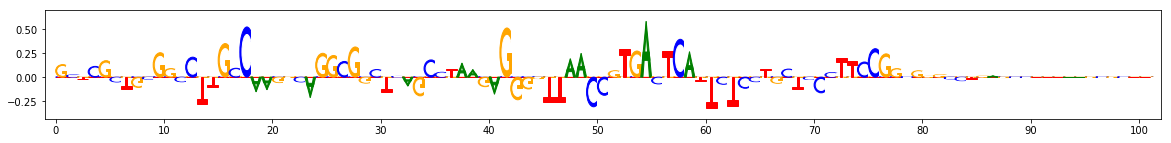

intgrad20_dinucshuffref10
0.5466846635972614


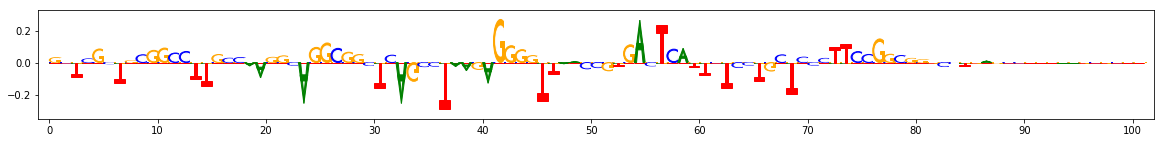

dlrescale_dinucshuffref10
1.0130051533225923


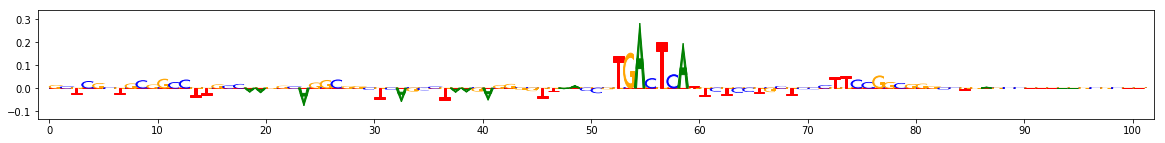

ism
5.058538913726807


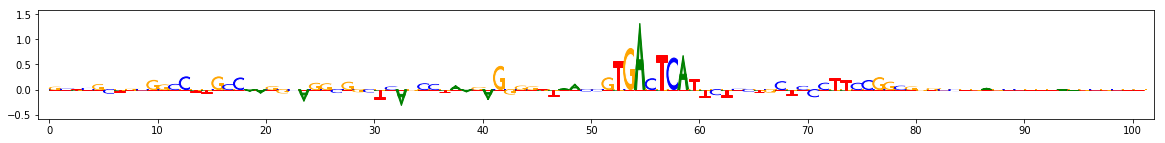

[('YTCCTCCCCC', 18), ('VGGAGGAR', 20), ('RCCGGAARYG', 21), ('AGAGGGCGCT', 29), ('CGCGCBCT', 29), ('GGGGCGKA', 31), ('AGAGGGCGCT', 40), ('GGGGCGKA', 42), ('GTTGCCANRB', 50), ('CGRCGCGCGS', 63), ('SGACCGAA', 70), ('CGRCGCGCGS', 70), ('BBCGKGGAAANK', 100), ('BCGCGGAR', 101), ('NNCRAABCCG', 104), ('VACWTTCC', 105), ('AAAACGMG', 107), ('SSGCGCSSGCGC', 116), ('CGCVYGCGCG', 117), ('CGGCGGCG', 117), ('GCGCGGCGCCGC', 119), ('CGRCGCGCGS', 120), ('SCGCSGCGSV', 121), ('GGCGGCGC', 124), ('TSGGAAMG', 142), ('NNCRAABCCG', 143), ('AAAACGMG', 145), ('NNCCGCTTMCSN', 155), ('TSGGAAMG', 177), ('CCGGAAAT', 177), ('GGRAGTGTTT', 179), ('NNATGASTCATN', 181), ('ATGACTCATC', 182), ('STTAVTCABH', 183), ('TGASTCAB', 184), ('ATGACTCA', 184), ('CAGTCATK', 185), ('SCYYTARR', 205), ('CCAAWCGS', 205), ('AAAACGMG', 207), ('NMAABRTTTVYH', 215), ('CCAAWCGS', 216), ('CTGTTTRC', 216), ('VACWTTCC', 240), ('AAAACGMG', 242), ('NNCRAABCCG', 251), ('DGGAAWTTSC', 251), ('VACWTTCC', 252), ('TSGGAAMG', 254), ('CCGGAAAT', 254), ('T

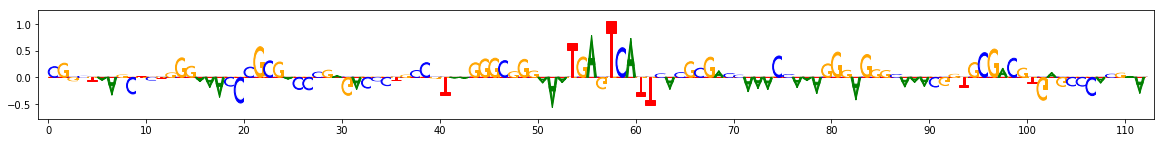

intgrad20_dinucshuffref10
0.5591000848275143


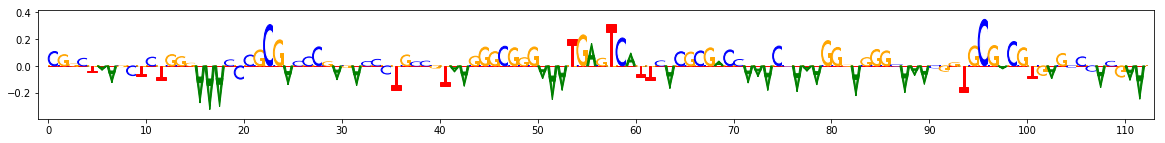

dlrescale_dinucshuffref10
0.9695036215009167


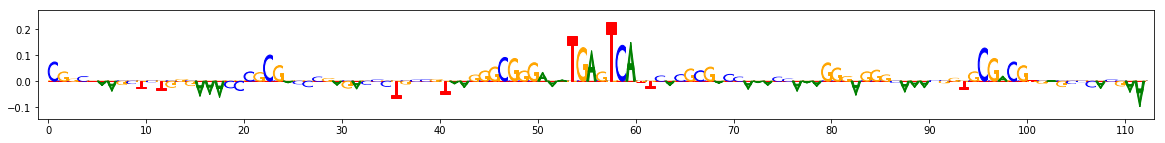

ism
5.316678524017334


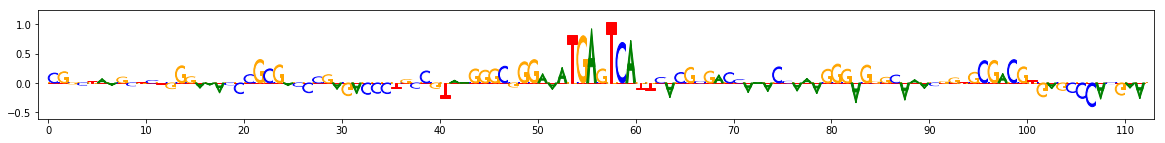

In [69]:
print_examples_with_scorediff_on_motif(
    method_to_hitscores=A549_motifname_to_method_to_hitscores['NNATGASTCATN'],
    motiflocs=A549_motifname_to_hitlocations['NNATGASTCATN'],
    ex_to_motifs = A549_extomotifs,
    onehot_seqs=A549_onehot_seqs,
    method_to_scores=A549_method_to_scores,
    method1='intgrad20_dinucshuffref10',
    method2='dlrescale_dinucshuffref10',
    numtoprint=4,
    minmethod2=1.0,
    motifname='NNATGASTCATN',
    methodstoprint=['gradtimesinp',
                   'intgrad20_dinucshuffref10',
                   'dlrescale_dinucshuffref10',
                   'ism'],
    region_around=50)

In [22]:
H1ESC_method_to_scores['dlrescale_dinucshuffref10'].shape

(5000, 400)

In [19]:
gradtimesinpweak[:10]

[(305, (1.5337487375363708, 1.0998166409321133)),
 (323, (2.469807455316186, 1.5062988365069032)),
 (158, (2.4690117090940475, 1.295021415688098)),
 (221, (2.668047532439232, 1.281425441242754)),
 (151, (2.591356836259365, 1.1357236817479135)),
 (67, (2.6538983583450317, 1.0991299659013745)),
 (34, (3.4696376752108335, 1.8731268579140297)),
 (94, (3.782871723175049, 2.148943451419473)),
 (330, (4.142824411392212, 2.505111641064287)),
 (293, (2.79308420419693, 1.047756281681358))]

In [24]:
H1Sox2_motif_scores.keys()

dict_keys(['dldefault_dinucshuffref10', 'dlrescale_dinucshuffref10', 'dlrescale_gcref', 'dlrescale_zeroref', 'gradtimesinp', 'intgrad10_dinucshuffref10', 'intgrad10_gcref', 'intgrad10_zeroref', 'intgrad20_dinucshuffref10', 'intgrad20_gcref', 'intgrad20_zeroref', 'ism'])